# Second NN Model - non-linear



In [ ]:
import torch
import sklearn
from torch import nn # neural network graphs
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

def plt_predictions(train_data,
                     train_labels,
                     test_data ,
                     test_labels,
                     predictions = None):
  """
  Plots training data, test data amd compares predictions.
  """
  plt.figure(figsize=(10,7))

  plt.scatter(train_data, train_labels, c = "b", s = 4, label = "Training data")

  plt.scatter(test_data, test_labels, c = "g", s = 4, label = "Testing data")


  if predictions is not None:
    plt.scatter(test_data,predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 10})

## Dataset

In [ ]:
from sklearn.datasets import make_circles

n_samples = 1000

x, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)

In [ ]:
#make dataframe of circle data
import pandas as pd

circles = pd.DataFrame({"X1": x[:,0],
                        "X2": x[:,1],
                        "label": y})
circles.head(1000)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


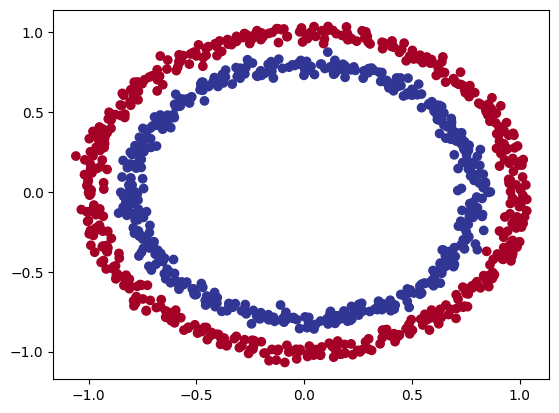

In [ ]:
plt.scatter(x=x[:, 0],
            y=x[:, 1],
            c = y,
            cmap = plt.cm.RdYlBu);

In [ ]:
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size = 0.2, #0.2 = 20% wil be test and 80% trained
                                                    random_state = 42)

In [ ]:
len(x_train), len(x_test),

(800, 200)

## Model

In [ ]:
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    # Create 2 nn.Linear layers
    self.layers = nn.Sequential(
        nn.Linear(in_features = 2, out_features = 128),
        nn.ReLU(),
        nn.Linear(in_features = 128, out_features = 128),
        nn.ReLU(),
        nn.Linear(128, 1)
    )

  # Define a forward method
  def forward(self, x):
    return self.layers(x) # x -> layer1 -> layer2

# 4. Instace of model

model_0 = CircleModel().to(device)
model_0

CircleModel(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)

## Loss Function, Optimizer


In [ ]:

# Setup Loss function
loss_fn = nn.BCELoss() # - requires inouts to have gone trought the sigmoid activation prior to input bce loss
loss_fn = nn.BCEWithLogitsLoss() #- sigmoid activation function built in

optimizer = torch.optim.Adam(params = model_0.parameters(),
                            lr = 0.01)

## Accuracy

In [ ]:
# Calculating acuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## Sigmoid

In [ ]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(x_test.to(device))[:5]
  y_logits

In [ ]:
# Use the sigmoid
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4926],
        [0.4986],
        [0.4863],
        [0.4953],
        [0.4931]], device='cuda:0')

## Training loop


In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  # Forward pass
  y_logits = model_0(x_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calculate Loss and Accuracy
  loss = loss_fn(y_logits,
                 y_train)

  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss backward
  loss.backward()

  # Optimizer steps
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(x_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)

    #Print
    if epoch % 10 == 0:
      print(f"Epoch: {epoch}, Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test accuacy: {test_acc:.2f}%")

Epoch: 0, Loss: 0.69321, Acc: 45.38% | Test Loss: 0.68143, Test accuacy: 50.00%
Epoch: 10, Loss: 0.37230, Acc: 99.75% | Test Loss: 0.35961, Test accuacy: 98.50%
Epoch: 20, Loss: 0.04724, Acc: 100.00% | Test Loss: 0.06152, Test accuacy: 100.00%
Epoch: 30, Loss: 0.00717, Acc: 100.00% | Test Loss: 0.01937, Test accuacy: 100.00%
Epoch: 40, Loss: 0.00246, Acc: 100.00% | Test Loss: 0.01117, Test accuacy: 100.00%
Epoch: 50, Loss: 0.00141, Acc: 100.00% | Test Loss: 0.00727, Test accuacy: 100.00%
Epoch: 60, Loss: 0.00105, Acc: 100.00% | Test Loss: 0.00581, Test accuacy: 100.00%
Epoch: 70, Loss: 0.00088, Acc: 100.00% | Test Loss: 0.00534, Test accuacy: 100.00%
Epoch: 80, Loss: 0.00078, Acc: 100.00% | Test Loss: 0.00515, Test accuacy: 100.00%
Epoch: 90, Loss: 0.00072, Acc: 100.00% | Test Loss: 0.00494, Test accuacy: 100.00%
Epoch: 100, Loss: 0.00066, Acc: 100.00% | Test Loss: 0.00471, Test accuacy: 100.00%
Epoch: 110, Loss: 0.00061, Acc: 100.00% | Test Loss: 0.00450, Test accuacy: 100.00%
Epoch: 

###Evaulation

In [ ]:
import requests
from pathlib import Path

# Download helper functions

if Path("helper_functions.py").is_file():
  print("file exist")
else:
  print("downloading")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)



downloading


In [ ]:
from helper_functions import plot_predictions, plot_decision_boundary

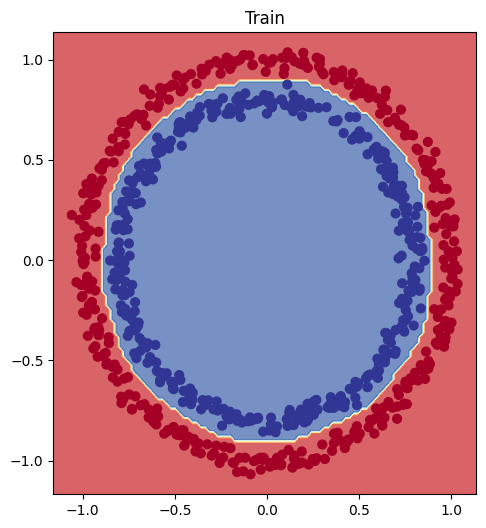

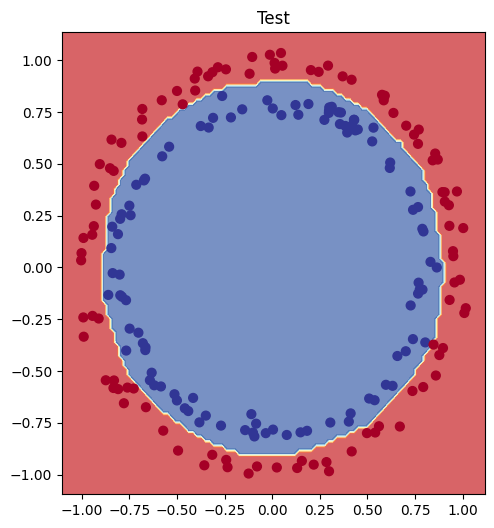

In [ ]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, x_train, y_train)
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("Test")
plot_decision_boundary(model_0, x_test, y_test)

tensor([ 0,  0,  0,  0,  5, 10, 15])


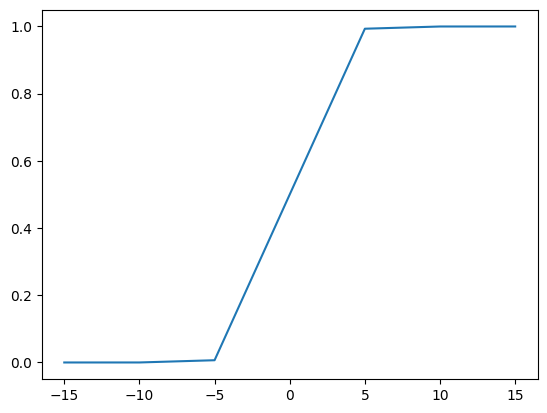

In [ ]:
A = torch.tensor([-15, -10, -5, 0, 5, 10, 15])
print(torch.relu(A))
plt.plot(A, torch.sigmoid(A))

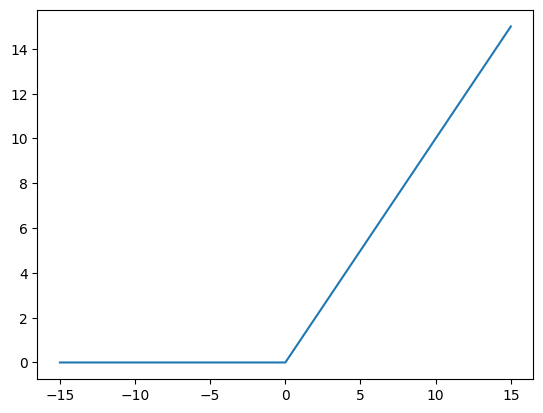

In [ ]:
plt.plot(A, torch.relu(A))